In [4]:
!pip install -q openai pandas matplotlib seaborn
!pip install -q torch pandas sentence-transformers umap-learn scikit-learn matplotlib seaborn
!pip install -q openai pandas numpy sklearn umap-learn matplotlib seaborn tqdm


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracke

In [ ]:
API_KEY = 'sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP'

In [ ]:
You are a dataset conversion bot. You are to generate a set of question response pairs that explain the attached data chunk.

In [ ]:

# Import required libraries
import os
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, LoggingHandler
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import h5py

# Function to process a JSON file and extract the relevant data
def extract_data(file_path):
    with open(file_path) as file:
        data = json.load(file)
        
    extracted_data = []
    for document in data:
        for turn in document['TURNS']:
            for name in turn['NAMES']:
                extracted_data.append({
                    'name': name,
                    'utterance': ' '.join(turn['UTTERANCES']),
                    'turn_number': turn['NUMBER']
                })
    return extracted_data

# Function to process all JSON files in a folder and extract data
def process_folder(folder_path):
    all_data = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                data = extract_data(file_path)
                all_data.extend(data)
    return all_data

# Function to save embeddings to an HDF5 file with proper encoding
def save_embeddings_to_hdf5(embeddings, data, filename):
    with h5py.File(filename, 'w') as f:
        f.create_dataset('embeddings', data=embeddings)
        names_encoded = [name.encode('utf8') for name in data['name'].values]
        utterances_encoded = [utt.encode('utf8') for utt in data['utterance'].values]
        f.create_dataset('names', data=names_encoded)
        f.create_dataset('utterances', data=utterances_encoded)
        f.create_dataset('turn_numbers', data=data['turn_number'].values)

# Main function to execute the script
def main():
    # Specify the folder path containing the JSON files
    folder_path = '/workspace/slice-monorepo/cl_cr3/aligneddata'
    
    # Process all JSON files and extract the data
    print("Processing JSON files...")
    data = process_folder(folder_path)
    
    # Convert the extracted data to a DataFrame
    df = pd.DataFrame(data)
    
    # Load a pre-trained SentenceTransformer model
    model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
    
    # Embed all utterances in large batches
    print("Embedding utterances...")
    embeddings = model.encode(df['utterance'].tolist(), batch_size=4096, show_progress_bar=True, convert_to_tensor=True)
    
    # Convert embeddings to CPU for further processing
    embeddings = embeddings.cpu().numpy()
    
    # Save embeddings to an HDF5 file
    print("Saving embeddings to HDF5 file...")
    save_embeddings_to_hdf5(embeddings, df, 'utterance_embeddings.h5')
    
    # Reduce dimensions using UMAP
    print("Reducing dimensions using UMAP...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
    umap_embeddings = reducer.fit_transform(embeddings)
    
    # Perform KMeans clustering
    print("Performing KMeans clustering...")
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(umap_embeddings)
    cluster_labels = kmeans.labels_
    
    # Add UMAP and cluster labels to the DataFrame
    df['umap_x'] = umap_embeddings[:, 0]
    df['umap_y'] = umap_embeddings[:, 1]
    df['cluster'] = cluster_labels
    
    # Visualize the UMAP embeddings with clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='umap_x', y='umap_y', hue='cluster', data=df, palette='viridis', s=5)
    plt.title('UMAP projection with KMeans clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Cluster')
    plt.show()
    
    # Visualize the UMAP embeddings colored by names
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='umap_x', y='umap_y', hue='name', data=df, palette='tab20', s=5)
    plt.title('UMAP projection colored by names')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

if __name__ == '__main__':
    main()


In [ ]:
# Install necessary packages
!pip install pandas umap-learn scikit-learn matplotlib seaborn h5py

# Import required libraries
import numpy as np
import pandas as pd
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

# Function to load embeddings from an HDF5 file with proper decoding
def load_embeddings_from_hdf5(filename):
    with h5py.File(filename, 'r') as f:
        embeddings = np.array(f['embeddings'])
        names = [name.decode('utf8') for name in f['names']]
        utterances = [utt.decode('utf8') for utt in f['utterances']]
        turn_numbers = np.array(f['turn_numbers'])
    
    return embeddings, names, utterances, turn_numbers

# Function to reduce dimensions using UMAP with batching
def umap_with_batches(embeddings, batch_size=10000, n_neighbors=15, min_dist=0.1, metric='cosine'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    n_batches = int(np.ceil(embeddings.shape[0] / batch_size))
    
    umap_embeddings = []
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, embeddings.shape[0])
        batch_embeddings = embeddings[start_idx:end_idx]
        umap_batch = reducer.fit_transform(batch_embeddings)
        umap_embeddings.append(umap_batch)
    
    return np.concatenate(umap_embeddings, axis=0)

# Function to save UMAP embeddings to an HDF5 file
def save_umap_embeddings_to_hdf5(umap_embeddings, df, filename):
    with h5py.File(filename, 'w') as f:
        f.create_dataset('umap_embeddings', data=umap_embeddings)
        f.create_dataset('names', data=np.string_(df['name'].values))
        f.create_dataset('utterances', data=np.string_(df['utterance'].values))
        f.create_dataset('turn_numbers', data=df['turn_number'].values)
        f.create_dataset('clusters', data=df['cluster'].values)

# Main function to execute the script
def main():
    # Load embeddings from HDF5 file
    embeddings_file = 'utterance_embeddings.h5'
    embeddings, names, utterances, turn_numbers = load_embeddings_from_hdf5(embeddings_file)
    
    # Convert to DataFrame for easier handling
    df = pd.DataFrame({
        'name': names,
        'utterance': utterances,
        'turn_number': turn_numbers
    })
    
    # Reduce dimensions using UMAP with batching
    print("Reducing dimensions using UMAP with batching...")
    umap_embeddings = umap_with_batches(embeddings, batch_size=10000, n_neighbors=15, min_dist=0.1, metric='cosine')
    
    # Perform KMeans clustering
    print("Performing KMeans clustering...")
    n_clusters = 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(umap_embeddings)
    cluster_labels = kmeans.labels_
    
    # Add UMAP and cluster labels to the DataFrame
    df['umap_x'] = umap_embeddings[:, 0]
    df['umap_y'] = umap_embeddings[:, 1]
    df['cluster'] = cluster_labels
    
    # Save UMAP embeddings to an HDF5 file
    print("Saving UMAP embeddings to HDF5 file...")
    save_umap_embeddings_to_hdf5(umap_embeddings, df, 'umap_embeddings.h5')
    
    # Visualize the UMAP embeddings with clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='umap_x', y='umap_y', hue='cluster', data=df, palette='viridis', s=5)
    plt.title('UMAP projection with KMeans clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Cluster')
    plt.savefig('umap_kmeans_clusters.png')
    plt.show()
    
    # Visualize the UMAP embeddings colored by names
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='umap_x', y='umap_y', hue='name', data=df, palette='tab20', s=5)
    plt.title('UMAP projection colored by names')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend(title='Name', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('umap_colored_by_names.png')
    plt.show()

if __name__ == '__main__':
    main()



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Reducing dimensions using UMAP with batching...


Processing JSON files...
Analyzing data for the name: MARISHA...
Total Utterances: 329039
Average Utterance Length: 44.29
Median Utterance Length: 31.00
Min Utterance Length: 2
Max Utterance Length: 2147
Average Turn Difference: 8.61
Median Turn Difference: 3.00
Min Turn Difference: 0
Max Turn Difference: 2377
Standard Deviation of Utterance Lengths: 58.43
Standard Deviation of Turn Differences: 16.02
Total Turn Numbers: 329039
Total Unique Turn Numbers: 3864


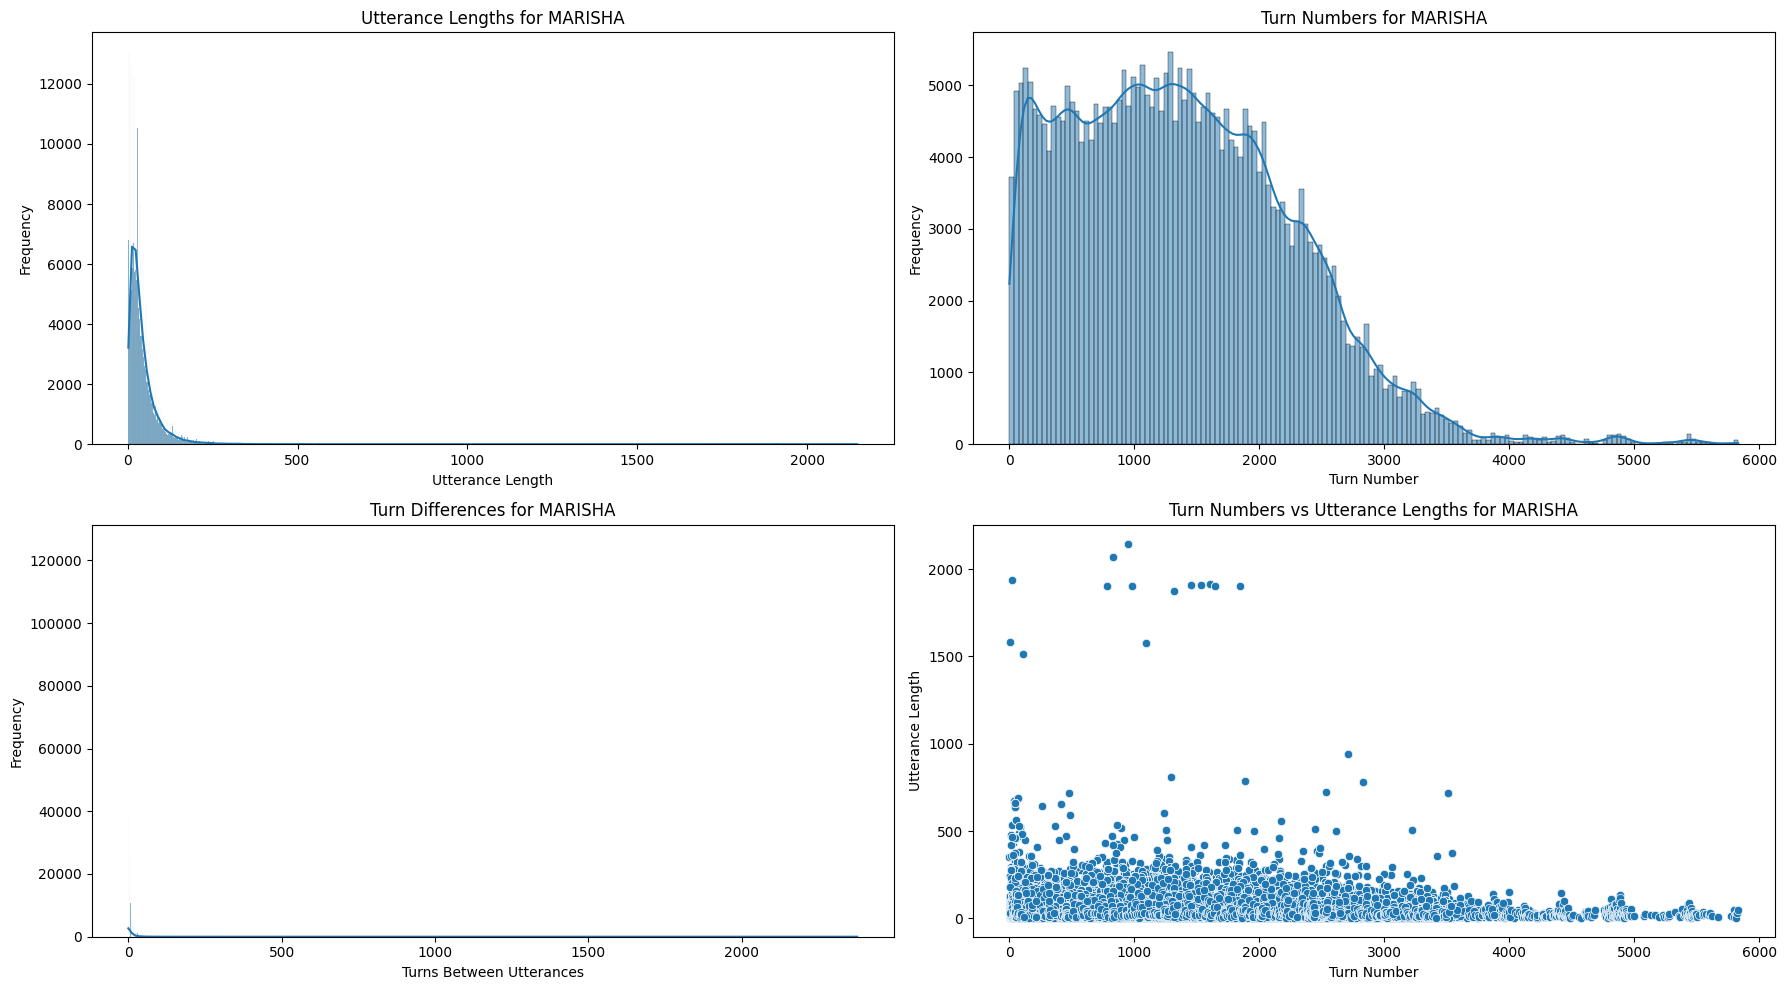

In [5]:
import os
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to process a JSON file and extract the relevant data
def extract_data(file_path):
    with open(file_path) as file:
        data = json.load(file)
        
    extracted_data = []
    for document in data:
        for turn in document['TURNS']:
            for name in turn['NAMES']:
                extracted_data.append({
                    'name': name,
                    'utterance': ' '.join(turn['UTTERANCES']),
                    'turn_number': turn['NUMBER']
                })
    return extracted_data

# Function to process all JSON files in a folder and extract data
def process_folder(folder_path):
    all_data = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                data = extract_data(file_path)
                all_data.extend(data)
    return all_data

# Function to analyze data based on the given name
def analyze_data(data, name):
    name_data = [entry for entry in data if entry['name'] == name]
    
    if not name_data:
        print(f"No data found for the name: {name}")
        return None
    
    df = pd.DataFrame(name_data)
    df['utterance_length'] = df['utterance'].apply(len)
    df['turn_difference'] = df['turn_number'].diff().fillna(0).astype(int)
    
    # Removing invalid turn differences
    df = df[df['turn_difference'] >= 0]
    
    avg_utterance_length = df['utterance_length'].mean()
    median_utterance_length = df['utterance_length'].median()
    min_utterance_length = df['utterance_length'].min()
    max_utterance_length = df['utterance_length'].max()
    
    avg_turn_difference = df['turn_difference'].mean()
    median_turn_difference = df['turn_difference'].median()
    min_turn_difference = df['turn_difference'].min()
    max_turn_difference = df['turn_difference'].max()

    analysis_results = {
        'total_utterances': len(df),
        'average_utterance_length': avg_utterance_length,
        'median_utterance_length': median_utterance_length,
        'min_utterance_length': min_utterance_length,
        'max_utterance_length': max_utterance_length,
        'average_turn_difference': avg_turn_difference,
        'median_turn_difference': median_turn_difference,
        'min_turn_difference': min_turn_difference,
        'max_turn_difference': max_turn_difference,
        'utterance_lengths': df['utterance_length'].tolist(),
        'turn_differences': df['turn_difference'].tolist(),
        'turn_numbers': df['turn_number'].tolist()
    }
    
    return analysis_results

# Function to visualize the analysis results
def visualize_analysis(analysis_results, name):
    if not analysis_results:
        return
    
    utterance_lengths = analysis_results['utterance_lengths']
    turn_differences = analysis_results['turn_differences']
    turn_numbers = analysis_results['turn_numbers']

    plt.figure(figsize=(18, 10))

    # Plot 1: Utterance lengths
    plt.subplot(2, 2, 1)
    sns.histplot(utterance_lengths, kde=True)
    plt.title(f'Utterance Lengths for {name}')
    plt.xlabel('Utterance Length')
    plt.ylabel('Frequency')
    
    # Plot 2: Turn numbers
    plt.subplot(2, 2, 2)
    sns.histplot(turn_numbers, kde=True)
    plt.title(f'Turn Numbers for {name}')
    plt.xlabel('Turn Number')
    plt.ylabel('Frequency')

    # Plot 3: Turn differences
    plt.subplot(2, 2, 3)
    sns.histplot(turn_differences, kde=True)
    plt.title(f'Turn Differences for {name}')
    plt.xlabel('Turns Between Utterances')
    plt.ylabel('Frequency')
    
    # Plot 4: Scatter plot of Turn numbers vs Utterance lengths
    plt.subplot(2, 2, 4)
    sns.scatterplot(x=turn_numbers, y=utterance_lengths)
    plt.title(f'Turn Numbers vs Utterance Lengths for {name}')
    plt.xlabel('Turn Number')
    plt.ylabel('Utterance Length')
    
    plt.tight_layout()
    plt.show()

# Function to print detailed statistics
def print_statistics(analysis_results):
    if not analysis_results:
        return

    print(f"Total Utterances: {analysis_results['total_utterances']}")
    print(f"Average Utterance Length: {analysis_results['average_utterance_length']:.2f}")
    print(f"Median Utterance Length: {analysis_results['median_utterance_length']:.2f}")
    print(f"Min Utterance Length: {analysis_results['min_utterance_length']}")
    print(f"Max Utterance Length: {analysis_results['max_utterance_length']}")
    print(f"Average Turn Difference: {analysis_results['average_turn_difference']:.2f}")
    print(f"Median Turn Difference: {analysis_results['median_turn_difference']:.2f}")
    print(f"Min Turn Difference: {analysis_results['min_turn_difference']}")
    print(f"Max Turn Difference: {analysis_results['max_turn_difference']}")
    
    # Additional statistics
    print(f"Standard Deviation of Utterance Lengths: {pd.Series(analysis_results['utterance_lengths']).std():.2f}")
    print(f"Standard Deviation of Turn Differences: {pd.Series(analysis_results['turn_differences']).std():.2f}")
    print(f"Total Turn Numbers: {len(analysis_results['turn_numbers'])}")
    print(f"Total Unique Turn Numbers: {len(set(analysis_results['turn_numbers']))}")

# Main function to execute the script
def main():
    # Specify the folder path containing the JSON files
    folder_path = '/workspace/slice-monorepo/cl_cr3/aligneddata'
    
    # Process all JSON files and extract the data
    print("Processing JSON files...")
    data = process_folder(folder_path)
    
    # Specify the name to analyze
    name_to_analyze = 'MARISHA'
    
    # Analyze the data based on the given name
    print(f"Analyzing data for the name: {name_to_analyze}...")
    analysis_results = analyze_data(data, name_to_analyze)
    
    # Print the analysis results
    if analysis_results:
        print_statistics(analysis_results)
        
        # Visualize the analysis results
        visualize_analysis(analysis_results, name_to_analyze)
    else:
        print(f"No data found for the name: {name_to_analyze}")

if __name__ == '__main__':
    main()


In [ ]:
import os 
import json
import openai
import re
import uuid
import time
import random
import multiprocessing
from openai import OpenAI

# Function to process a JSON file and extract summary chunks with metadata
def extract_summary_chunks_with_metadata(file_path):
    with open(file_path) as file:
        data = json.load(file)
        
    summary_chunks = []
    for document in data:
        if 'CHUNK' in document:
            chunk_data = {
                'chunk': document['CHUNK'],
                'metadata': document['ALIGNMENT'],
                'filename': os.path.basename(file_path)
            }
            summary_chunks.append(chunk_data)
    return summary_chunks

# Function to process all JSON files in a folder and extract summary chunks with metadata
def process_folder(folder_path):
    all_summary_chunks = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                summary_chunks = extract_summary_chunks_with_metadata(file_path)
                all_summary_chunks.extend(summary_chunks)
    return all_summary_chunks

# Function to generate questions based on summary chunks using GPT-4
def generate_responses(api_key, input_text, model_config):
    client = OpenAI(api_key=api_key)
    responses = []

    while True:
        try:
            response = client.chat.completions.create(
                model=model_config.get('name', "gpt-3.5-turbo"),
                messages=[
                    {"role": "system", "content": "You are a dataset conversion bot. You are to generate a set of question response pairs that explain the attached data chunk."},
                    {"role": "user", "content": input_text}
                ],
                max_tokens=model_config.get('max_tokens', 300),
                temperature=model_config.get('temperature', 0.7),
                top_p=model_config.get('top_p', 0.9)
            )

            response_data = {
                'uuid': str(uuid.uuid4()),
                'response_content': response.choices[0].message.content,
                'configuration': {
                    'max_tokens': model_config.get('max_tokens', 300),
                    'temperature': model_config.get('temperature', 0.7),
                    'top_p': model_config.get('top_p', 0.9),
                    'model': model_config.get('name', "gpt-3.5-turbo")
                }
            }
            responses.append(response_data)
            break
        except openai.RateLimitError as e:
            wait_time = random.uniform(1, 300)
            print(f"Rate limit hit. Waiting for {wait_time} seconds. Error: {e}")
            time.sleep(wait_time)
        except openai.APIError as e:
            print(f"OpenAI API returned an API Error: {e}")
            break
        except openai.APIConnectionError as e:
            print(f"Failed to connect to OpenAI API: {e}")
            time.sleep(2)
        except Exception as e:
            print(f"Unexpected error: {e}")
            break

    return responses

# Function to parse question-answer pairs from the response content
def parse_qa_pairs(response_content):
    qa_pairs = []
    pairs = response_content.split('\n\n')
    for pair in pairs:
        if 'Q:' in pair and 'A:' in pair:
            question = pair.split('Q:')[1].split('A:')[0].strip()
            answer = pair.split('A:')[1].strip()
            qa_pairs.append({'question': question, 'answer': answer})
    return qa_pairs

# Worker function for multiprocessing
def worker(chunk_data_list, model_config, api_key, return_list, progress_dict, lock):
    for chunk_data in chunk_data_list:
        responses = generate_responses(api_key, chunk_data['chunk'], model_config)
        for response in responses:
            qa_pairs = parse_qa_pairs(response['response_content'])
            result = {
                'chunk': chunk_data['chunk'],
                'metadata': chunk_data['metadata'],
                'filename': chunk_data['filename'],
                'qa_pairs': qa_pairs,
                'inference_metadata': response['configuration']
            }
            return_list.append(result)
        # Update progress
        with lock:
            progress_dict['processed_chunks'] += 1
            print(f"Processed {progress_dict['processed_chunks']} / {progress_dict['total_chunks']} chunks")

# Main function to execute the script
def main():
    # Specify your OpenAI API key
    API_KEY = 'sk-proj-7MAfZbOm9lPY28pubTiRT3BlbkFJGgn73o5e6sVCjoTfoFAP'
    
    # Specify the folder path containing the JSON files
    folder_path = '/workspace/slice-monorepo/cl_cr3/aligneddata'
    
    # Extract summary chunks from all JSON files in the folder
    print("Extracting summary chunks from JSON files...")
    summary_chunks = process_folder(folder_path)
    total_chunks = len(summary_chunks)
    print(f"Extracted {total_chunks} summary chunks.")
    
    # Configuration for OpenAI model
    model_config = {
        "name": "gpt-3.5-turbo",
        "max_tokens": 300,
        "temperature": 0.7,
        "top_p": 0.9
    }
    
    # Define number of workers and chunk size
    num_workers = 20
    chunk_size = 5
    
    # Using multiprocessing to process chunks in parallel
    manager = multiprocessing.Manager()
    return_list = manager.list()
    progress_dict = manager.dict({'processed_chunks': 0, 'total_chunks': total_chunks})
    lock = manager.Lock()
    jobs = []

    # Divide the work into chunks of size `chunk_size`
    chunked_data = [summary_chunks[i:i + chunk_size] for i in range(0, total_chunks, chunk_size)]
    
    # Run a set number of workers at a time
    for i in range(0, len(chunked_data), num_workers):
        current_jobs = chunked_data[i:i + num_workers]
        for chunk_data_list in current_jobs:
            p = multiprocessing.Process(target=worker, args=(chunk_data_list, model_config, API_KEY, return_list, progress_dict, lock))
            jobs.append(p)
            p.start()
        
        for job in jobs:
            job.join()
        jobs = []  # Reset jobs list for the next set of workers
    
    # Collecting the results
    generated_questions = list(return_list)
    
    # Save the generated questions to a JSON file
    output_file = 'generated_questions.json'
    with open(output_file, 'w') as f:
        json.dump(generated_questions, f, indent=4)
    
    print(f"Generated questions saved to {output_file}")

if __name__ == '__main__':
    main()


In [1]:
import json
import os
import re

def process_json_file(file_path):
    # Open the JSON file
    with open(file_path) as file:
        data = json.load(file)

    # Initialize metrics
    total_chunks = len(data)
    total_turns = 0
    total_words = 0
    unique_names = set()
    name_utterances = {}

    # Iterate over each document (chunk)
    for document in data:
        # Update total turns
        total_turns += len(document['TURNS'])

        # Iterate over each turn
        for turn in document['TURNS']:
            # Update unique names
            unique_names.update(turn['NAMES'])

            # Update name utterances
            for name in turn['NAMES']:
                if name not in name_utterances:
                    name_utterances[name] = []
                name_utterances[name].append(turn['NUMBER'])

            # Update total words
            for utterance in turn['UTTERANCES']:
                total_words += len(utterance.split())

    # Return metrics
    return total_chunks, total_turns, total_words, unique_names, name_utterances

def process_folder(folder_path):
    # Initialize summary metrics
    total_files = 0
    total_chunks = 0
    total_turns = 0
    total_words = 0
    unique_names = set()
    common_names = None
    name_utterances = {}

    # Initialize campaign-specific metrics
    campaign_metrics = {}

    # Iterate over all files and subdirectories in the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if the file has a .json extension
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                chunks, turns, words, names, file_name_utterances = process_json_file(file_path)

                # Extract the campaign number from the file name
                campaign_number = re.findall(r'C\d+', file)[0]

                # Update summary metrics
                total_files += 1
                total_chunks += chunks
                total_turns += turns
                total_words += words
                unique_names.update(names)

                # Update common names
                if common_names is None:
                    common_names = set(names)
                else:
                    common_names &= names

                # Update name utterances
                for name, utterances in file_name_utterances.items():
                    if name not in name_utterances:
                        name_utterances[name] = []
                    name_utterances[name].extend(utterances)

                # Update campaign-specific metrics
                if campaign_number not in campaign_metrics:
                    campaign_metrics[campaign_number] = {
                        'total_files': 0,
                        'total_chunks': 0,
                        'total_turns': 0,
                        'total_words': 0,
                        'unique_names': set(),
                        'common_names': None,
                        'name_utterances': {}
                    }
                campaign_metrics[campaign_number]['total_files'] += 1
                campaign_metrics[campaign_number]['total_chunks'] += chunks
                campaign_metrics[campaign_number]['total_turns'] += turns
                campaign_metrics[campaign_number]['total_words'] += words
                campaign_metrics[campaign_number]['unique_names'].update(names)

                if campaign_metrics[campaign_number]['common_names'] is None:
                    campaign_metrics[campaign_number]['common_names'] = set(names)
                else:
                    campaign_metrics[campaign_number]['common_names'] &= names

                for name, utterances in file_name_utterances.items():
                    if name not in campaign_metrics[campaign_number]['name_utterances']:
                        campaign_metrics[campaign_number]['name_utterances'][name] = []
                    campaign_metrics[campaign_number]['name_utterances'][name].extend(utterances)

    # Calculate averages
    avg_chunks_per_file = total_chunks / total_files
    avg_turns_per_file = total_turns / total_files
    avg_words_per_utterance = total_words / total_turns

    # Calculate average steps between utterances for common names
    avg_steps_between_utterances = {}
    for name in common_names:
        utterances = name_utterances[name]
        steps = [utterances[i] - utterances[i-1] for i in range(1, len(utterances))]
        avg_steps = sum(steps) / len(steps)
        avg_steps_between_utterances[name] = avg_steps

    # Calculate campaign-specific averages
    for campaign_number, metrics in campaign_metrics.items():
        metrics['avg_chunks_per_file'] = metrics['total_chunks'] / metrics['total_files']
        metrics['avg_turns_per_file'] = metrics['total_turns'] / metrics['total_files']
        metrics['avg_words_per_utterance'] = metrics['total_words'] / metrics['total_turns']

        metrics['avg_steps_between_utterances'] = {}
        for name in metrics['common_names']:
            utterances = metrics['name_utterances'][name]
            steps = [utterances[i] - utterances[i-1] for i in range(1, len(utterances))]
            avg_steps = sum(steps) / len(steps)
            metrics['avg_steps_between_utterances'][name] = avg_steps

    # Print summary metrics
    print("Summary Metrics:")
    print(f"Total Files: {total_files}")
    print(f"Total Chunks: {total_chunks}")
    print(f"Total Turns: {total_turns}")
    print(f"Total Words: {total_words}")
    print(f"Unique Names: {', '.join(unique_names)}")
    print(f"Number of Unique Names: {len(unique_names)}")
    print(f"Average Chunks per File: {avg_chunks_per_file:.2f}")
    print(f"Average Turns per File: {avg_turns_per_file:.2f}")
    print(f"Average Words per Utterance: {avg_words_per_utterance:.2f}")
    print(f"Common Names: {', '.join(common_names)}")
    print("Average Steps Between Utterances for Common Names:")
    for name, avg_steps in avg_steps_between_utterances.items():
        print(f"  {name}: {avg_steps:.2f}")

    # Print campaign-specific metrics
    for campaign_number, metrics in campaign_metrics.items():
        print(f"\nCampaign {campaign_number} Metrics:")
        print(f"Total Files: {metrics['total_files']}")
        print(f"Total Chunks: {metrics['total_chunks']}")
        print(f"Total Turns: {metrics['total_turns']}")
        print(f"Total Words: {metrics['total_words']}")
        print(f"Unique Names: {', '.join(metrics['unique_names'])}")
        print(f"Number of Unique Names: {len(metrics['unique_names'])}")
        print(f"Average Chunks per File: {metrics['avg_chunks_per_file']:.2f}")
        print(f"Average Turns per File: {metrics['avg_turns_per_file']:.2f}")
        print(f"Average Words per Utterance: {metrics['avg_words_per_utterance']:.2f}")
        print(f"Common Names: {', '.join(metrics['common_names'])}")
        print("Average Steps Between Utterances for Common Names:")
        for name, avg_steps in metrics['avg_steps_between_utterances'].items():
            print(f"  {name}: {avg_steps:.2f}")

# Specify the folder path
folder_path = '/workspace/slice-monorepo/cl_cr3/aligneddata'

# Process all JSON files in the folder and its subfolders
process_folder(folder_path)

Summary Metrics:
Total Files: 1140
Total Chunks: 52796
Total Turns: 2942362
Total Words: 41232406
Unique Names: CHRIS PERKINS, IPHONE, ORION, DARIN, ERIKA, SAM, ANNET, COMPUTER, BECCA, LAURA, MAX, PRODUCER, ALL - SAM, TAYLOR, KAI, AUDIENCE MEMBER, BRIAN, ALL - SAM - MATT, CHRIS HARDWICK, KIT, ASHLEY, FELICIA, MARISHA, LENORE, MARK, TOY IN BAG, AMANDINE, KHARY, SEAN, SUMALEE, KEVIN, DEBORAH, RYAN, TALIESIN, ALL - MATT, HECTOR, CAST, NOELLE, ALL - TALIESIN, AUDIENCE, GENERATED VOICE, JOE, BABS, LUCAS, OFFSCREEN, MARY, IVAN, YURI, PATRICK ROTHFUSS, ERIC, WIL, CHRIS WILLMOTT, ALL - ORION, JOEL, LIAM, JOEY, YASMINE, ALEC, JON, ALL - TRAVIS - ORION - LIAM - AHSLEY - MATT, JORE, MATT, CAMERAMAN, CREW, ALLISON, AMY, STEVE, SCREEN, ANNOUNCER, ZAC, CHRIS PRAMAS, DENISE, TRAVIS, ALL, WILL, SOUND, IFY
Number of Unique Names: 77
Average Chunks per File: 46.31
Average Turns per File: 2581.02
Average Words per Utterance: 14.01
Common Names: MATT, MARISHA
Average Steps Between Utterances for Common Na